# [1] Moving Average Convergence Divergence (MACD) for Forex Trading

* MACD is the most commonly used momentum indicator to determine an asset's uptrend or downtrend. (Though RSI is a more reliable momentum indicator as compared to MACD. If you want to check the work on RSI indicator, please visit [this kernel](https://www.kaggle.com/code/chandrimad31/forex-trading-momentum-analysis-rsi-divergence)).
* For MACD, if the 2 moving averages are moving closer together it is said to be *converging* and if they are moving away from each other it is said to be *diverging*.
* MACD triggers technical signals when it crosses above (to buy) or below (to sell) its signal line. The speed of crossovers can also be taken as a signal of the market to know if the asset is overbought or oversold. 

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [57]:
# import data
df = pd.read_csv('../data/all_stocks_5yr.csv')
df.columns=['date_time', 'open', 'high', 'low', 'close', 'volume','name']
df.drop('name',inplace=True,axis=1)
df=df[df['volume']!=0] #discard volume zero data points
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail() # printing tail just to check how many rows are present

,date_time,open,high,low,close,volume
619031,2/1/2018,76.84,78.27,76.69,77.82,2982259
619032,2/2/2018,77.53,78.12,76.73,76.78,2595187
619033,2/5/2018,76.64,76.92,73.18,73.83,2962031
619034,2/6/2018,72.74,74.56,72.13,73.27,4924323
619035,2/7/2018,72.70,75.00,72.69,73.86,4534912


In [58]:
df = df.set_index(['date_time']) 
df.head()

,open,high,low,close,volume
date_time,,,,,
2/8/2013,15.07,15.12,14.63,14.75,8407500
2/11/2013,14.89,15.01,14.26,14.46,8882000
2/12/2013,14.45,14.51,14.10,14.27,8126000
2/13/2013,14.30,14.94,14.25,14.66,10259500
2/14/2013,14.94,14.96,13.16,13.99,31879900


In [59]:
# There is 1 day of missing values. Using linear interpolate to fill that value
df = df.interpolate()

## Visualize Data for a Short Horizon

In [60]:
dfpl = df #choosing a slice of 100 datapoints
plt.figure(figsize=(12, 6))
plt.plot(dfpl['close'].ilo, label='close')
plt.title('EUR/USD Close Price History')
plt.xlabel('date_time')
plt.ylabel('price')
plt.show()

AttributeError: 'Series' object has no attribute 'ilo'

<Figure size 1200x600 with 0 Axes>

## Visualize Data for a Long Horizon

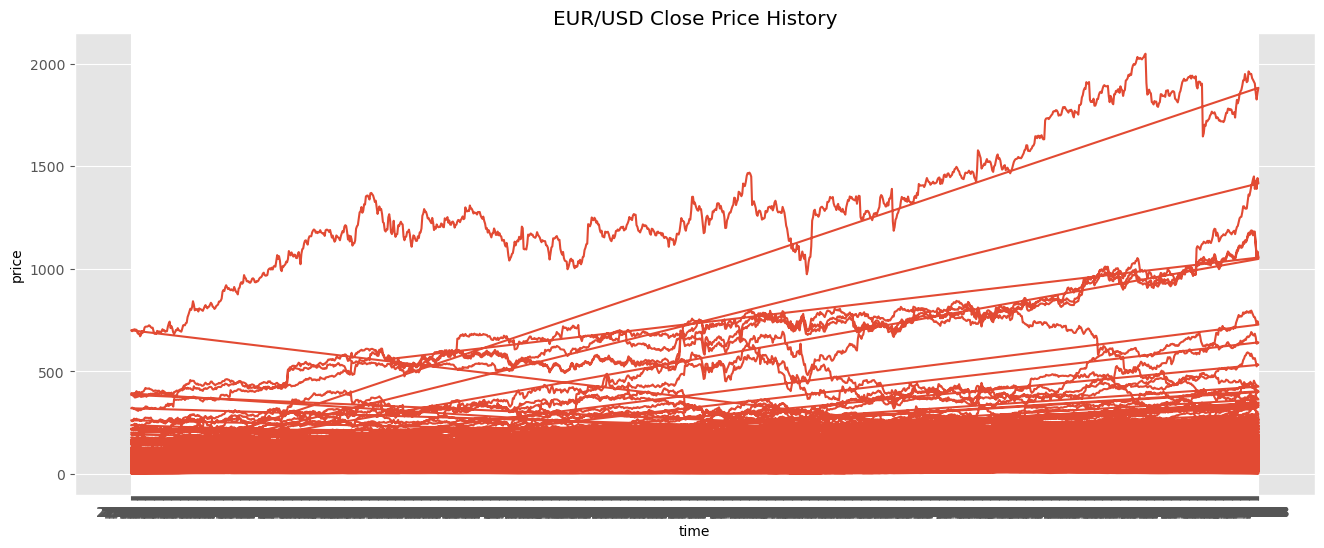

In [61]:
dfpl = df # choosing a slice of 600 datapoints
plt.figure(figsize=(16, 6))
plt.plot(dfpl['close'], label='close')
plt.title('EUR/USD Close Price History')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

## Calculate the MACD and Signal lines

For divergence calculation, taking a long horizon is better. Hence choosing the slice of dataframe having 600 datapoints

In [62]:
dfpl = df# choosing the long horizon i.e. the slice having 600 datapoints

# Calculate the short term exponetial moving average (EMA) - 12 periods
ShortEMA = dfpl.close.ewm(span=12, adjust=False).mean()
# Calculate the long term exponetial moving average (EMA) - 26 periods
LongEMA = dfpl.close.ewm(span=26, adjust = False).mean()
# Calculate the MACD line
MACD = ShortEMA - LongEMA
# Calculate the signal line
signal = MACD.ewm(span=9, adjust=False).mean()

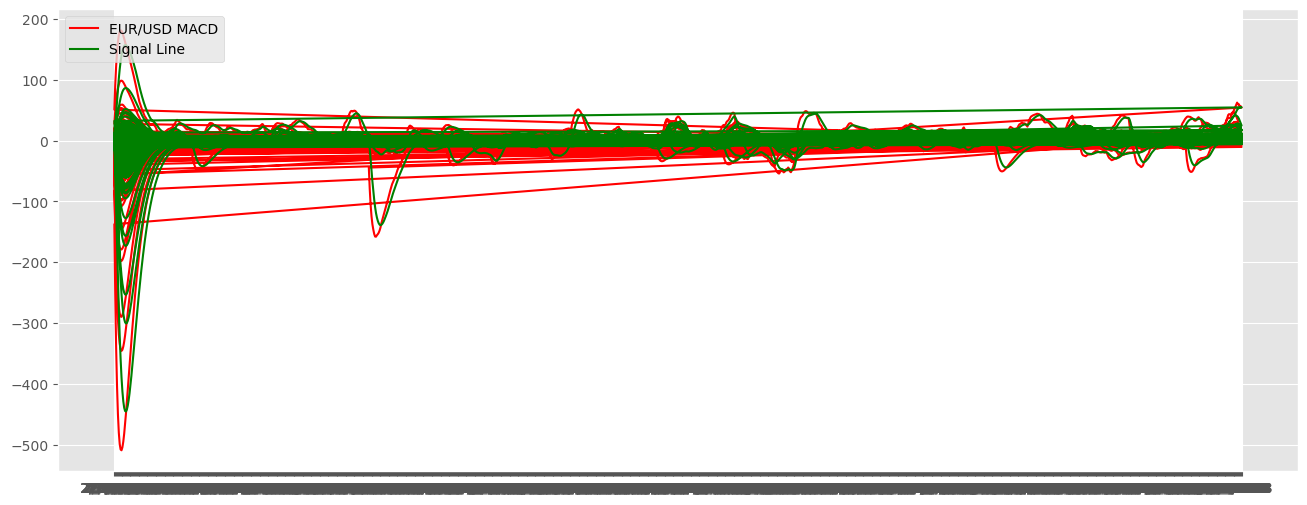

In [63]:
# plotting chart
plt.figure(figsize=(16, 6))
plt.plot(dfpl.index, MACD, label = 'EUR/USD MACD', color = 'red')
plt.plot(dfpl.index, signal, label = 'Signal Line', color = 'green')
plt.legend(loc='upper left')
plt.show()

In [64]:
dfpl['MACD'] = MACD
dfpl['Signal'] = signal
dfpl.head()

,open,high,low,close,volume,MACD,Signal
date_time,,,,,,,
2/8/2013,15.07,15.12,14.63,14.75,8407500,0.000000,0.000000
2/11/2013,14.89,15.01,14.26,14.46,8882000,-0.023134,-0.004627
2/12/2013,14.45,14.51,14.10,14.27,8126000,-0.056152,-0.014932
2/13/2013,14.30,14.94,14.25,14.66,10259500,-0.050270,-0.021999
2/14/2013,14.94,14.96,13.16,13.99,31879900,-0.098535,-0.037307


In [65]:
# Create a function - when to buy and sell
def buy_sell(signal):
    Buy = []
    Sell = []
    flag = -1 # Tells us if the price continues to rise or decreases - flag changes when the two lines cross again

    for i in range(0, len(signal)):
        if signal['MACD'][i] > signal['Signal'][i]: # MACD has crossed the signal line
            Sell.append(np.nan)
            if flag != 1: 
                Buy.append(signal['close'][i])
                flag = 1 # We have been here
            else:
                Buy.append(np.nan)
        
        elif signal['MACD'][i] < signal['Signal'][i]: # Signal line has crossed the MACD line
            Buy.append(np.nan)
            if flag != 0: 
                Sell.append(signal['close'][i])
                flag = 0 
            else:
                Sell.append(np.nan)
        else:
            Sell.append(np.nan)
            Buy.append(np.nan)
    
    return (Buy, Sell)

In [66]:
# Create buy and sell columns in the working slice of the df
a = buy_sell(dfpl)
dfpl['Buy_Signal_Price']= a[0]
dfpl['Sell_Signal_Price'] = a[1]
dfpl.head()

,open,high,low,close,volume,MACD,Signal,Buy_Signal_Price,Sell_Signal_Price
date_time,,,,,,,,,
2/8/2013,15.07,15.12,14.63,14.75,8407500,0.000000,0.000000,NaN,NaN
2/11/2013,14.89,15.01,14.26,14.46,8882000,-0.023134,-0.004627,NaN,14.46
2/12/2013,14.45,14.51,14.10,14.27,8126000,-0.056152,-0.014932,NaN,NaN
2/13/2013,14.30,14.94,14.25,14.66,10259500,-0.050270,-0.021999,NaN,NaN
2/14/2013,14.94,14.96,13.16,13.99,31879900,-0.098535,-0.037307,NaN,NaN


## Visualize Buy and Sell Signals

We will now spot out the buying and selling signals for the horizon containing 600 datapoints we've chosen.

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 10))

ax1.scatter(dfpl.index, dfpl['Buy_Signal_Price'], color='green', label='Buy', marker = '^', alpha =1)
ax1.scatter(dfpl.index, dfpl['Sell_Signal_Price'], color='red', label='Sell', marker = 'v', alpha =1)
ax1.plot(dfpl['close'], label = 'Close Price', alpha = 0.35)
ax1.set_title('Close price Buy & Sell Signals')
ax1.set_ylabel('Close price')
ax1.legend(loc='upper left')

ax2.set_title('MACD & Signal Lines')
ax2.plot(dfpl.index, MACD, label = 'EUR/USD MACD', color = 'red')
ax2.plot(dfpl.index, signal, label = 'Signal Line', color = 'blue')
ax2.set_xlabel('date_time')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [67]:
buy_signal_entries = dfpl[dfpl.Buy_Signal_Price.notna()].copy()
buy_signal_entries

,open,high,low,close,volume,MACD,Signal,Buy_Signal_Price,Sell_Signal_Price
date_time,,,,,,,,,
3/5/2013,14.01,14.050,13.7100,14.05,7676100,-0.262598,-0.292267,14.05,NaN
4/26/2013,16.38,16.730,16.1600,16.59,7272100,0.168202,0.162872,16.59,NaN
7/3/2013,16.06,16.800,16.0400,16.75,2625800,-0.218502,-0.227601,16.75,NaN
9/3/2013,16.38,16.640,16.1100,16.39,4178200,-0.535943,-0.538205,16.39,NaN
10/17/2013,20.72,21.060,20.6400,21.00,4487000,0.719787,0.711655,21.00,NaN
...,...,...,...,...,...,...,...,...,...
4/17/2017,53.09,53.570,53.0000,53.50,1975296,-0.195900,-0.223552,53.50,NaN
8/21/2017,60.82,61.470,60.6500,61.35,1806313,-0.360113,-0.380397,61.35,NaN
10/12/2017,64.24,64.935,64.1950,64.91,1837949,0.234364,0.218770,64.91,NaN


In [68]:
#Export the buy signal results
buy_signal_entries.to_csv('MACD_buy_signal_results.csv', index=False)

In [69]:
sell_signal_entries = dfpl[dfpl.Sell_Signal_Price.notna()].copy()
sell_signal_entries

,open,high,low,close,volume,MACD,Signal,Buy_Signal_Price,Sell_Signal_Price
date_time,,,,,,,,,
2/11/2013,14.89,15.01,14.260,14.46,8882000,-0.023134,-0.004627,NaN,14.46
4/2/2013,16.48,16.50,15.710,15.74,14595600,0.536393,0.590789,NaN,15.74
5/23/2013,17.48,18.45,17.440,18.19,7482400,0.551471,0.559614,NaN,18.19
8/7/2013,18.84,18.98,18.520,18.87,4318500,0.476571,0.491626,NaN,18.87
10/16/2013,20.57,20.73,20.450,20.62,3478800,0.709128,0.709622,NaN,20.62
...,...,...,...,...,...,...,...,...,...
6/2/2017,62.78,63.30,62.390,62.50,4110099,1.653890,1.655006,NaN,62.50
9/21/2017,64.50,64.86,64.200,64.24,1232176,0.806550,0.821613,NaN,64.24
10/25/2017,64.81,64.99,64.280,64.38,1593840,0.415991,0.461911,NaN,64.38


In [70]:
#Export the sell signal results
sell_signal_entries.to_csv('MACD_sell_signal_results.csv', index=False)

In [71]:
dfpl.to_csv('MACD_results.csv', index=False)

# [2] Bollinger Bands for Forex Trading

Bollinger Bands are also a tool used to determine overbought and oversold conditions. But using only these bands to trade is a risky strategy, because it focuses on price and volatility, ignoring a lot of other relevant information.

Bollinger Bands are envelopes plotted at a standard deviation (STD) level above and below a simple moving average (SMA) of the price. Since the distance of the bands is based on standard deviation, they adjust to volatility swing of the underlying price. These Bands use 2 main parameters: Period (we've taken a window of 20) and Standard Deviation (STD).

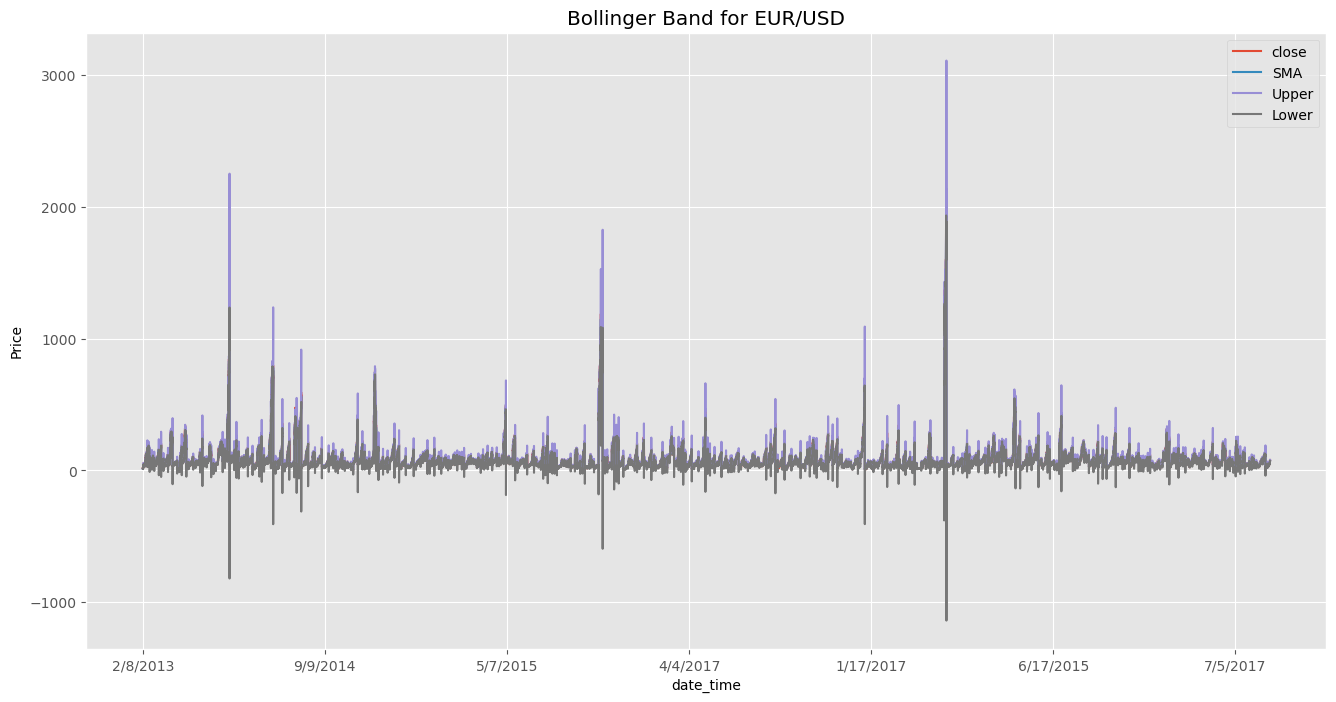

In [72]:
dfpl = df # choosing a slice of 1000 datapoints

period = 20 #say window is 20
# simple moving average(SMA)
dfpl['SMA'] = dfpl['close'].rolling(window=period).mean()
# standard deviation
dfpl['STD'] = dfpl['close'].rolling(window=period).std()
# Upper Bollinger Band
dfpl['Upper'] = dfpl['SMA'] + (dfpl['STD'] * 2)
# Lower Bollinger Band
dfpl['Lower'] = dfpl['SMA'] - (dfpl['STD'] * 2)
column_list = ['close', 'SMA', 'Upper', 'Lower']

# Plotting
dfpl[column_list].plot(figsize=(16, 8))
plt.title('Bollinger Band for EUR/USD')
plt.ylabel('Price')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

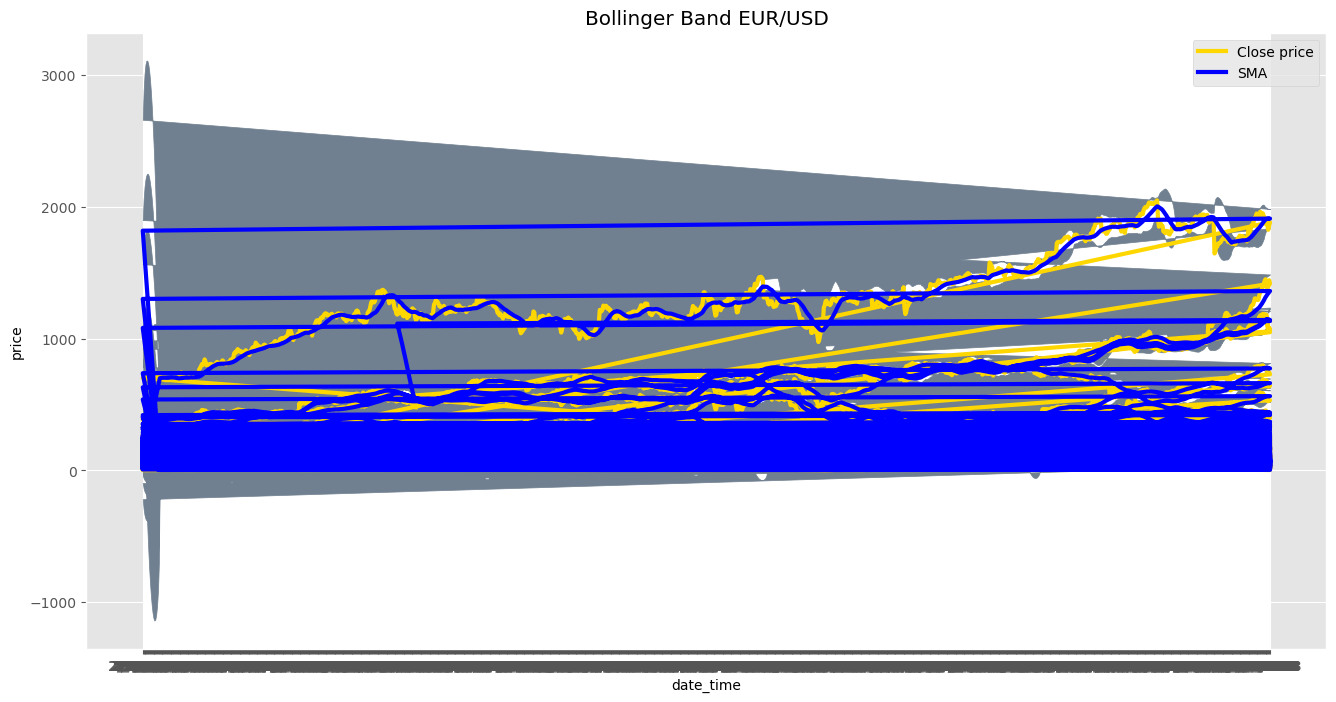

In [73]:
# Plot and shade the area between the two Bollinger bands
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,1,1)
x_axis = dfpl.index
ax.fill_between(x_axis, dfpl['Upper'], dfpl['Lower'], color= 'slategrey')
# Plot the closing price and moving average 
ax.plot(x_axis, dfpl['close'], color='gold', lw=3, label='Close price')
ax.plot(x_axis, dfpl['SMA'], color='blue', lw=3, label='SMA')
ax.set_title('Bollinger Band EUR/USD')
ax.set_xlabel('date_time')
ax.set_ylabel('price')
ax.ticklabel_format(style='plain', axis='y')
ax.legend()
plt.show()

In [74]:
# Get the buy and sell signals
new_dfpl = dfpl[period-1:]
new_dfpl

,open,high,low,close,volume,MACD,Signal,Buy_Signal_Price,Sell_Signal_Price,SMA,STD,Upper,Lower
date_time,,,,,,,,,,,,,
3/8/2013,14.99,15.20,14.84,14.92,10593700,-0.014946,-0.190357,NaN,NaN,14.0075,0.599086,15.205672,12.809328
3/11/2013,14.85,15.15,14.71,15.13,6961800,0.062550,-0.139775,NaN,NaN,14.0265,0.629145,15.284791,12.768209
3/12/2013,15.14,15.60,14.95,15.50,8999100,0.152070,-0.081406,NaN,NaN,14.0785,0.705238,15.488976,12.668024
3/13/2013,15.54,16.20,15.48,15.91,11380000,0.253179,-0.014489,NaN,NaN,14.1605,0.815414,15.791328,12.529672
3/14/2013,15.98,16.36,15.93,16.25,8383300,0.356634,0.059735,NaN,NaN,14.2400,0.935364,16.110727,12.369273
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/1/2018,76.84,78.27,76.69,77.82,2982259,1.533067,1.597054,NaN,77.82,76.4605,2.097659,80.655818,72.265182
2/2/2018,77.53,78.12,76.73,76.78,2595187,1.360930,1.549829,NaN,NaN,76.6730,1.882795,80.438590,72.907410
2/5/2018,76.64,76.92,73.18,73.83,2962031,0.975229,1.434909,NaN,NaN,76.6965,1.841753,80.380007,73.012993


In [75]:
# function to get the buy & sell singnals

def get_signal(data):

    buy_signal = []
    sell_signal = []

    for i in range(len(data['close'])):
        if data['close'][i] > data['Upper'][i]: # Check to see if the Close is greater than Upper -> sell
            sell_signal.append(data['close'][i])
            buy_signal.append(np.nan)
        elif data['close'][i] < data['Lower'][i]: # Check to see if the Close is lower than Lower -> buy
            buy_signal.append(data['close'][i])
            sell_signal.append(np.nan)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
    
    return (buy_signal, sell_signal)

In [76]:
# Create columns with the buy and sell signals

new_dfpl['Buy'] = get_signal(new_dfpl)[0]
new_dfpl['Sell'] = get_signal(new_dfpl)[1]

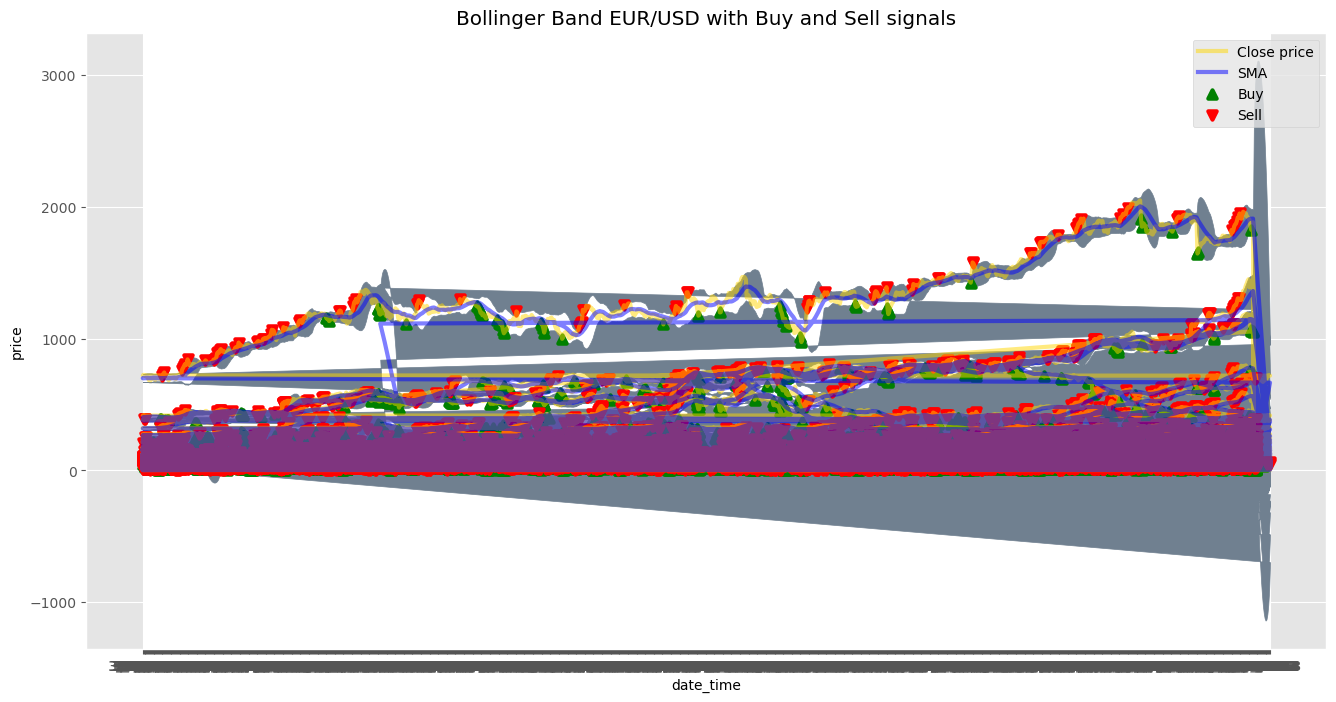

In [77]:
# Plot the buy and sell signals

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,1,1)
x_axis = new_dfpl.index
ax.fill_between(x_axis, new_dfpl['Upper'], new_dfpl['Lower'], color= 'slategrey')
ax.plot(x_axis, new_dfpl['close'], color='gold', lw=3, label='Close price', alpha=0.5)
ax.plot(x_axis, new_dfpl['SMA'], color='blue', lw=3, label='SMA', alpha=0.5)
ax.scatter(x_axis, new_dfpl['Buy'], lw=3, color='green', label='Buy', marker='^', alpha=1)
ax.scatter(x_axis, new_dfpl['Sell'], lw=3, color='red', label='Sell', marker='v', alpha=1)
ax.set_title('Bollinger Band EUR/USD with Buy and Sell signals')
ax.set_xlabel('date_time')
ax.set_ylabel('price')
ax.ticklabel_format(style='plain', axis='y')
ax.legend()
plt.show()

In [78]:
buy_signal_entries = new_dfpl[new_dfpl.Buy.notna()].copy()

In [79]:
#Export the buy signal results
buy_signal_entries.to_csv('Bollinger_buy_signal_results.csv', index=False)

In [80]:
sell_signal_entries = new_dfpl[new_dfpl.Sell.notna()].copy()

In [81]:
#Export the sell signal results
sell_signal_entries.to_csv('Bollinger_sell_signal_results.csv', index=False)

In [82]:
new_dfpl.to_csv('new_dfpl_results.csv', index=False)

# Acknowledgement :
I learnt the entire methodology and the code for functions implementation from [Code Trading Cafe](https://www.youtube.com/c/CodeTradingCafe/about)